# 1- Introduction

## 1.1 Problem statement

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

THe challenge is to build an NLP model to predict whether a Tweet is actually describing real emergency or not

## 1.2 Load the packages

In [133]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords 

# nltk.download('stopwords')
# nltk.download('punkt')

from nltk.tokenize import word_tokenize
import re

import torch
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

# Check if we have CUDA
print("CUDA device(s): " + str(torch.cuda.device_count()))

CUDA device(s): 0


## 1.3 Load the data

In [90]:
sample_submission = pd.read_csv("data/sample_submission.csv")
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

# 2. Preprocessing and EDA

In [91]:
print("Train data shape: " + str(train.shape))
print("Test data shape: " + str(test.shape))
print("Test/Train ratio: " +str(np.round(test.shape[0]/train.shape[0]*100, 2)) + "%")

Train data shape: (7613, 5)
Test data shape: (3263, 4)
Test/Train ratio: 42.86%


Ok, we have 7.6k rows of training data, and 3.2k rows of test data (~40% the size of the train data)

In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Ok, so the `id` and `target` columns in the training dataset are good, no NULL values there, of course. Let's have a look at the other 3 columns.

In [93]:
train.describe(include='object')

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


## 2.1 "Clean" the Texts

In [107]:
stop_words = set(stopwords.words('english'))

def text_preprocess(text):
    #Change to lower case
    text = text.lower()
    #Handle &amp; special character and others
    text = text.replace("&amp;", " and ")
    text = text.replace("w/", " with ")
    
    #Remove/change mention
    text = re.sub(r'@\w+', 'xmention', text)
    #Remove/change url
    text = re.sub(r'http.?://[^\s]+[\s]?', 'xurl', text)
    #Points, hastags, commas, all kinds of symbols 
    text = re.sub(r'[^a-z0-9\s]', '', text)
    #Remove white spaces
    #text = re.sub("\n", ' ', text)
    text = text.replace("\n", " ")
    text = text.lstrip()
    text = text.rstrip()
    
    #Remove stopwords
    text = ' '.join([t for t in text.split() if t not in stop_words])
    
    return text

train['text_clean'] = [text_preprocess(t) for t in train.text.values]

list(set(train[train.target == 1].text_clean.values))[:10]

['rt grantfactory grants funds weymouth meeting seawalls flood grants set thursday night xurl',
 'boulder deputies waiting bomb squad detonate grenade like one found stearns lake today xurl',
 'xmention yes would think since college 8892 difficult think bioterrorism esp bc dispersed',
 'xmention allow farrakhan challenge 10000 males rise commit mass murder miami xurl',
 'mh370 intact part lifts odds plane glided crashed sea xurl',
 'usatoday todays frontpage bioterror lab faced secret sanctions rickperry doesnt make cut foxnew xurl',
 'volleyball attack ii volleyball training machine sets simulation xurlxurl',
 'riot police intervene southampton vitesse arnhem supporters clash fans clash buildup second xurl',
 'traffic collision ambulance enroute elkhorn blvd walerga rd sacramento xurl',
 'xmention definite triple crown threat harper']

In [73]:
train.text.shape, train.text_clean.shape, train.text.isnull().sum(), train.text_clean.isnull().sum()
train[train.text_clean.str.contains("how tough some people")]

,id,keyword,location,text,target,text_clean,nchar
7213,10332,weapon,Denver Colorado. Fun Times,Lol\nLook how tough some people talk that live...,1,lol look how tough some people talk that live ...,140


In [74]:
train.keyword.value_counts().reset_index().rename(columns={'keyword':'N'})

,index,N
0,fatalities,45
1,deluge,42
2,armageddon,42
3,damage,41
4,body%20bags,41
...,...,...
216,forest%20fire,19
217,epicentre,12
218,threat,11
219,inundation,10


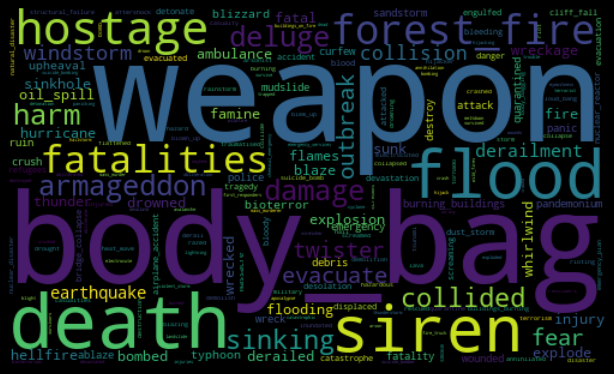

In [75]:
text = ' '.join(train.keyword.dropna().values).replace("%20", "_")
wordcloud = WordCloud(
    width = 500,
    height = 300,
    background_color = 'black',
    collocations=False,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [76]:
train.location.value_counts().reset_index().rename(columns={'location':'N'})

,index,N
0,USA,104
1,New York,71
2,United States,50
3,London,45
4,Canada,29
...,...,...
3336,"Shirley, NY",1
3337,btwn a rock and a hard place,1
3338,"Temecula, CA",1
3339,"Santa Maria, CA",1


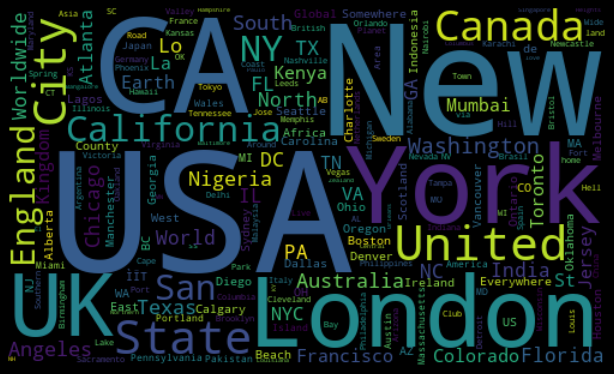

In [77]:
text = ' '.join(train.location.dropna().str.strip().replace(' ', "_").values).replace("%20", "_")
wordcloud = WordCloud(
    width = 500,
    height = 300,
    background_color = 'black',
    collocations=False,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Count if we have any retweets

In [78]:
temp = train.text.value_counts().reset_index()
temp = temp[temp.text > 1]
print(str(temp.shape[0]) + " unique texts - " + str(temp.text.sum()) + " tweets - " + str(np.round(temp.text.sum()/train.shape[0]*100, 2)) + "% of train data")

69 unique texts - 179 tweets - 2.35% of train data


## 2.1 Check to see if there are any big differences in disaster tweets and non-disaster tweets

In [79]:
list(set(train[train.target == 1].text_clean.values))[:10]

['xmention yo forreal we need to have like an emergency action plan incase donald trump becomes president whipe that lil baby',
 'plane from new york to kuwait diverts to uk after declaring state of emergency xurl',
 'cop pulls drunk driver to safety seconds before his car is hit by train xurlxurlvia xmention',
 'jkl issues hazardous weather outlook hwo  xurlwx',
 'police man killed ex grandmother after son wasn and 8217t named after him xurlomg absolutely crazy',
 'imagine a school where suicide bombing is being taught the teachers would say to the students  please pay xurl',
 'news fedex no longer to transport bioterror germs in wake of anthrax lab mishaps xurl',
 'hundreds feared drowned after another mediterranean asylum seeker boat sinking xurl',
 'our thoughts are with these local residents time for some heavy rain xurl',
 'families to sue over legionnaires more than 40 families affected by the fatal outbreak of legionnaires disease in edinburgh are to']

In [80]:
list(set(train[train.target == 0].text_clean.values))[:10]

['xmention xmention mega bloody marvellous',
 'we havent seen the devastation from the 2014 corp breaches yet be prepared get coverage xurlxurl',
 'the tubestrike is because tfl workers may have trouble planning downtime i hope none need emergency services xurl',
 'new ladies shoulder tote handbag faux leather hobo purse cross body bag womens xurlxurlrt en',
 'pft barkevious mingo missed browns practice with a mystery injury xurl',
 'shes kinda hot played on the radio today whats next disease to all the apocalypse has started everyone be careful',
 'whats the police or ambulance number in lesotho any body know',
 'my woman crush wedneday goes to the beautiful xmention loveyouuuu aintsheperty xurl',
 'xmention thank you for supporting the president the irandeal takes nuclear weapons out of the hands of iran and keeps everyone safer',
 'i hear the mumbling i hear the cackling i got em scared shook panicking']

### 2.1.2 Check tweet length

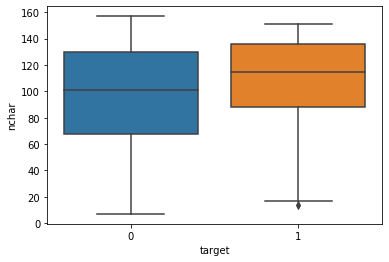

In [81]:
train['nchar'] = [len(t) for t in train.text.values]
# print(train.nchar.describe())
# print(train[train.target == 0].nchar.describe())
# print(train[train.target == 1].nchar.describe())
# sns.distplot(train[train.target == 0][['nchar']], hist=False, rug=True)
# sns.distplot(train[train.target == 1][['nchar']], hist=False, rug=True)
sns.boxplot(x="target", y = "nchar", data=train)
plt.show()

We can see that Disaster tweets tend to be longer than Non-disaster tweets. There are also some tweets with more than 140 characters, this is because of the use of emojis.

In [82]:
print(train[train.nchar > 150].text.values)
print()
print(train[train.nchar > 150].text_clean.values)

['@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?@VP'
 "when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"
 "It's was about 2:30 in the morning&amp;I went downstairs to watch some telly&amp;I accidentally made a loud bang&amp;my dad(who has a broken leg)walked-"]

['xmention if 90blks and 8whts colluded 2 take wht f xmention auth hostage and 2 make her look blk  with bioterrorism and use her lglorg idis id still hersxmention'
 'when youre taking a shower and someone flushes the toilet and you have 1 second to gtfo or you get burned'
 'its was about 230 in the morning and i went downstairs to watch some telly and i accidentally made a loud bang and my dadwho has a broken legwalked']


### 2.1.3 VADER Sentiment

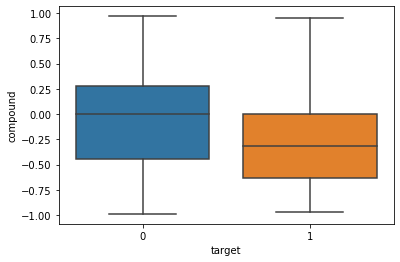

In [85]:
# import nltk
# nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

train['sid'] = [sid.polarity_scores(t) for t in train.text_clean.values]
train['compound'] = [d['compound'] for d in train.sid.values]

sns.boxplot(x='target', y='compound', data=train)

Ok, so we can see that VADER detects the disaster tweets as more negative than the non disaster tweets

## 2.2 Tokenizing text

In [109]:
train['tokens'] = train.text_clean.apply(lambda t:word_tokenize(t))
train['tokens'] = train['tokens'].values[0]
train[['tokens']].values[0][0]

['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']

In [111]:
train['tokens'].values

array([list(['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']),
       list(['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']),
       list(['residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected']),
       ..., list(['m194', '0104', 'utc5km', 'volcano', 'hawaii', 'xurl']),
       list(['police', 'investigating', 'ebike', 'collided', 'car', 'little', 'portugal', 'ebike', 'rider', 'suffered', 'serious', 'nonlife', 'threatening', 'injuries']),
       list(['latest', 'homes', 'razed', 'northern', 'california', 'wildfire', 'abc', 'news', 'xurl'])],
      dtype=object)

In [113]:
train.text_clean.values[0], train.text.values[0] 

('deeds reason earthquake may allah forgive us',
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all')

# 3. Train/test split and Model Creation

In [130]:
tweet_train, tweet_test, target_train, target_test = train_test_split(train['text_clean'], train['target'], test_size=0.25)

print("Train Features\t: " + str(tweet_train.shape))
print("Train Target\t: " + str(target_train.shape) + "\tLabel 1 (%): " + str(np.round(target_train.sum()/target_train.shape[0]*100, 2)))
print("Test Features\t: " + str(tweet_test.shape))
print("Test Target\t: " + str(target_test.shape) + "\tLabel 1 (%): " + str(np.round(target_test.sum()/target_test.shape[0]*100, 2)))


Train Features	: (5709,)
Train Target	: (5709,)	Label 1 (%): 43.07
Test Features	: (1904,)
Test Target	: (1904,)	Label 1 (%): 42.65


In [134]:
pipeline = Pipeline([
    ('bag_of_words', CountVectorizer(analyzer = text_preprocess)), 
    ('tfidf', TfidfTransformer()),
#     ('classifier', MultinomialNB()),
    ('classifier', LogisticRegression())
])

pipeline.fit(tweet_train, target_train)

/Users/mrakelinggara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('bag_of_words',
                 CountVectorizer(analyzer=<function text_preprocess at 0x1a3758b320>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                            

In [135]:
predictions = pipeline.predict(tweet_test)
print(classification_report(target_test, predictions))
print(confusion_matrix(target_test, predictions))
print(accuracy_score(target_test, predictions))

              precision    recall  f1-score   support

           0       0.69      0.76      0.72      1092
           1       0.63      0.55      0.59       812

    accuracy                           0.67      1904
   macro avg       0.66      0.65      0.66      1904
weighted avg       0.67      0.67      0.67      1904

[[825 267]
 [363 449]]
0.6691176470588235
